In [7]:
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession

import random
from random import randint
from pyspark.sql import functions as f
from pyspark.sql.types import StringType

import pandas as pd

In [2]:
spark_conf = (
    SparkConf()
        .set("spark.jars.packages", 'org.apache.hadoop:hadoop-client:3.3.4,org.apache.hadoop:hadoop-aws:3.3.4')
        .set("spark.driver.memory", "6g")
        .set("spark.hadoop.fs.s3a.endpoint", "minio:9000")
        .set("spark.hadoop.fs.s3a.access.key", "pPZWyzFK4auwPEHCrmuw")
        .set("spark.hadoop.fs.s3a.secret.key", "M8i0y8Ef9jDntigOXfTXhnqoCpZ5v7NVHwC7NhRd")
        .set("spark.hadoop.fs.s3a.path.style.access", "true")
        .set("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
        .set('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')
        .set("spark.hadoop.fs.s3a.connection.ssl.enabled", "false")
    )
sc = SparkContext.getOrCreate(spark_conf)
spark = SparkSession(sc)

In [3]:
print(f"Hadoop version = {sc._jvm.org.apache.hadoop.util.VersionInfo.getVersion()}")

Hadoop version = 3.3.4


# Data generation, snowflake schema

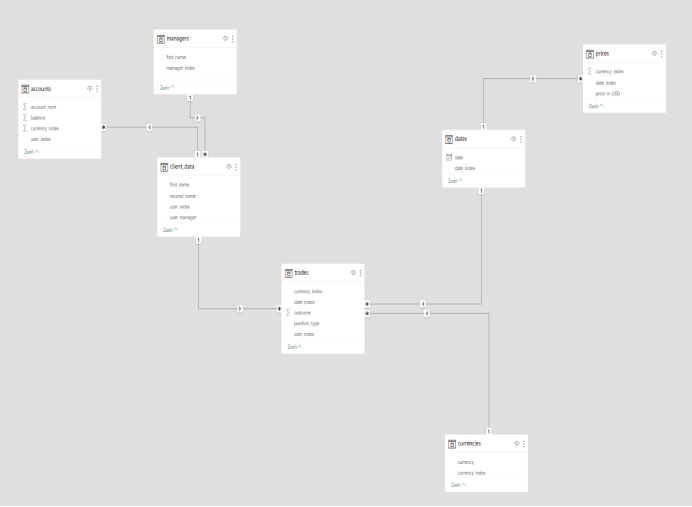

In [4]:
from datetime import date, timedelta
 
test_date1, test_date2 = date(2023, 10, 1), date(2023, 11, 1)
index = 0
res_dates = [(test_date1, index)]


while test_date1 != test_date2:
    index += 1
    test_date1 += timedelta(days=1)
    res_dates.append((test_date1, index))

In [12]:
currencies = [(0,'EUR'), (1,'USD'), (2,'PLN'), (3,'GBP'), (4,'AUD'), (5,'YEN')]
client_data = []
client_accounts = []
managers = [(i, f'name_{i%12}') for i in range(5_000)]
trades = []
prices = []
dates = res_dates

for user_num in range(20_000):
    user_accounts = []
    for account in range(randint(1,5)):
        user_accounts.append((
            user_num,
            user_num*10+account,
            0,
            random.choice(currencies)[0]
         ))
    client_accounts.extend(user_accounts)
    client_data.append((
        user_num,
        f'first_name_{random.randint(1,10)}',
        f'second_name_{random.randint(100,150)}',
        random.choice(managers)[0]
        ))
    for i in range(randint(5,20)):
        trades.append((
            user_num,
            random.choice(['Buy','Sell']),
            random.choice(user_accounts)[3],
            random.choice(dates)[1],
            randint(-500_000, 1_000_000)
        ))

for ind in dates:
    date = ind[1]
    for currency in currencies:
        if currency[1] != 'USD':
            prices.append((
                date,
                currency[0],
                random.uniform(1.2, 2.5)
            ))
        else:
            prices.append((
                date,
                currency[0],
                1.0
            ))

In [20]:
trades_rdd = sc.parallelize(trades)   #trades is the biggest table with average 250k rows
trades_rdd
trades_df = trades_rdd.toDF(['user_index', 'position_type', 'currency_index', 'date_index','outcome'])
trades_df.printSchema()

root
 |-- user_index: long (nullable = true)
 |-- position_type: string (nullable = true)
 |-- currency_index: long (nullable = true)
 |-- date_index: long (nullable = true)
 |-- outcome: long (nullable = true)



## Creating DataFrames

In [21]:
currencies_df = spark.createDataFrame(currencies, ['currency_index', 'currency'])
client_data_df = spark.createDataFrame(client_data, ['user_index', 'first_name', 'second_name', 'user_manager'])
client_accounts_df = spark.createDataFrame(client_accounts, ['user_index', 'account_num', 'balance', 'currency_index'])
managers_df = spark.createDataFrame(managers, ['manager_index', 'first_name'])
prices_df = spark.createDataFrame(prices, ['date_index', 'currency_index', 'price_in_USD'])
dates_df = spark.createDataFrame(dates, ['date', 'date_index'])


In [22]:
print('currencies ::')
currencies_df.printSchema()

print('client_data_df ::')
client_data_df.printSchema()

print('client_accounts_df ::')
client_accounts_df.printSchema()

print('managers_df ::')
managers_df.printSchema()

print('prices_df ::')
prices_df.printSchema()

print('prices_df ::')
dates_df.printSchema()

currencies ::
root
 |-- currency_index: long (nullable = true)
 |-- currency: string (nullable = true)

client_data_df ::
root
 |-- user_index: long (nullable = true)
 |-- first_name: string (nullable = true)
 |-- second_name: string (nullable = true)
 |-- user_manager: long (nullable = true)

client_accounts_df ::
root
 |-- user_index: long (nullable = true)
 |-- account_num: long (nullable = true)
 |-- balance: long (nullable = true)
 |-- currency_index: long (nullable = true)

managers_df ::
root
 |-- manager_index: long (nullable = true)
 |-- first_name: string (nullable = true)

prices_df ::
root
 |-- date_index: long (nullable = true)
 |-- currency_index: long (nullable = true)
 |-- price_in_USD: double (nullable = true)

prices_df ::
root
 |-- date: date (nullable = true)
 |-- date_index: long (nullable = true)



## saving data to minio

In [25]:
trades_df.write.format('parquet').mode('overwrite').save('s3a://project-bucket/trades')
currencies_df.write.format('parquet').mode('overwrite').save('s3a://project-bucket/currencies')
client_data_df.write.format('parquet').mode('overwrite').save('s3a://project-bucket/clients')
client_accounts_df.write.format('parquet').mode('overwrite').save('s3a://project-bucket/accounts')
managers_df.write.format('parquet').mode('overwrite').save('s3a://project-bucket/managers')
prices_df.write.format('parquet').mode('overwrite').save('s3a://project-bucket/prices')
dates_df.write.format('parquet').mode('overwrite').save('s3a://project-bucket/calendar')

In [26]:
# data saved to the minio bucket

In [27]:
#reading data
trades_df = spark.read.format("parquet").load('s3a://project-bucket/trades')
currencies_df = spark.read.format("parquet").load('s3a://project-bucket/currencies')
client_data_df = spark.read.format("parquet").load('s3a://project-bucket/clients')
client_accounts_df = spark.read.format("parquet").load('s3a://project-bucket/accounts')
managers_df = spark.read.format("parquet").load('s3a://project-bucket/managers')
prices_df = spark.read.format("parquet").load('s3a://project-bucket/prices')
dates_df = spark.read.format("parquet").load('s3a://project-bucket/calendar')

In [28]:
trades_df.show()
trades_df.printSchema()

+----------+-------------+--------------+----------+-------+
|user_index|position_type|currency_index|date_index|outcome|
+----------+-------------+--------------+----------+-------+
|      8686|          Buy|             2|        27|-201360|
|      8686|          Buy|             0|        27| 864267|
|      8686|         Sell|             0|        11|-299076|
|      8686|         Sell|             5|        30|  31946|
|      8686|         Sell|             2|        31| 723659|
|      8686|          Buy|             1|        31|  94009|
|      8686|          Buy|             1|        24|-303977|
|      8686|          Buy|             2|         5| -39312|
|      8686|         Sell|             5|         6| 989029|
|      8686|          Buy|             0|         1| 843604|
|      8686|          Buy|             1|        18| 811573|
|      8687|          Buy|             5|        21| 266908|
|      8687|         Sell|             3|        25|-439443|
|      8687|          Bu

## updating account ballances with trades outcome
At data generating stage all balances were set to '0' 

In [33]:
balances = trades_df.groupby(['user_index','currency_index']).sum('outcome').withColumnRenamed("sum(outcome)", "new_balance")
balances.show()

+----------+--------------+-----------+
|user_index|currency_index|new_balance|
+----------+--------------+-----------+
|      8692|             4|    1200734|
|      8702|             1|    3412690|
|      8747|             3|    2104205|
|      8831|             2|    3582021|
|      9196|             1|     245153|
|      9232|             4|    1842564|
|      9240|             1|     594414|
|      9341|             5|    -457863|
|      9361|             2|    -443190|
|      9382|             3|    2198478|
|      9620|             1|    -451884|
|      9634|             3|    3604875|
|      9884|             4|     227621|
|      9940|             4|   10359484|
|      8712|             2|      71863|
|      8737|             4|     554594|
|      8745|             0|     553065|
|      8834|             2|    2393052|
|      8925|             4|     187563|
|      9004|             2|     519762|
+----------+--------------+-----------+
only showing top 20 rows



In [38]:
updated_accounts_df = client_accounts_df.join(balances, ['user_index', 'currency_index'], 'left_outer').withColumn(
    'balance', f.when(balances['new_balance'].isNotNull(), balances['new_balance']).otherwise(0))   #it is possible to have account without trades
updated_accounts_df.show()

+----------+--------------+-----------+-------+-----------+
|user_index|currency_index|account_num|balance|new_balance|
+----------+--------------+-----------+-------+-----------+
|      9928|             4|      99284|2285593|    2285593|
|      9929|             4|      99290| 675792|     675792|
|      9929|             4|      99291| 675792|     675792|
|      9929|             1|      99292| 188653|     188653|
|      9929|             0|      99293|1931097|    1931097|
|      9930|             3|      99300|1392124|    1392124|
|      9931|             1|      99310|1956566|    1956566|
|      9931|             2|      99311|1276754|    1276754|
|      9931|             1|      99312|1956566|    1956566|
|      9931|             1|      99313|1956566|    1956566|
|      9932|             2|      99320|2440974|    2440974|
|      9933|             5|      99330|1047068|    1047068|
|      9933|             2|      99331|2298313|    2298313|
|      9934|             1|      99340| 

In [39]:
updated_accounts_df = updated_accounts_df.drop('new_balance')
updated_accounts_df.show()

+----------+--------------+-----------+-------+
|user_index|currency_index|account_num|balance|
+----------+--------------+-----------+-------+
|      9928|             4|      99284|2285593|
|      9929|             4|      99290| 675792|
|      9929|             4|      99291| 675792|
|      9929|             1|      99292| 188653|
|      9929|             0|      99293|1931097|
|      9930|             3|      99300|1392124|
|      9931|             1|      99310|1956566|
|      9931|             2|      99311|1276754|
|      9931|             1|      99312|1956566|
|      9931|             1|      99313|1956566|
|      9932|             2|      99320|2440974|
|      9933|             5|      99330|1047068|
|      9933|             2|      99331|2298313|
|      9934|             1|      99340| 382855|
|      9934|             5|      99341|3926546|
|      9934|             5|      99342|3926546|
|      9934|             2|      99343| 611574|
|      9934|             5|      99344|3

In [40]:
#starting all the balances were zeroed, and now the balances on each account are eaqual to outcome of month of trading
#now lets save this data
updated_accounts_df.write.format('parquet').mode('overwrite').save('s3a://project-bucket/updated-balances')
updated_accounts_df.show()

+----------+--------------+-----------+-------+
|user_index|currency_index|account_num|balance|
+----------+--------------+-----------+-------+
|      9928|             4|      99284|2285593|
|      9929|             4|      99290| 675792|
|      9929|             4|      99291| 675792|
|      9929|             1|      99292| 188653|
|      9929|             0|      99293|1931097|
|      9930|             3|      99300|1392124|
|      9931|             1|      99310|1956566|
|      9931|             2|      99311|1276754|
|      9931|             1|      99312|1956566|
|      9931|             1|      99313|1956566|
|      9932|             2|      99320|2440974|
|      9933|             5|      99330|1047068|
|      9933|             2|      99331|2298313|
|      9934|             1|      99340| 382855|
|      9934|             5|      99341|3926546|
|      9934|             5|      99342|3926546|
|      9934|             2|      99343| 611574|
|      9934|             5|      99344|3

### Blances are updated, lets find out who is the richest of the customers
The balances are in different currencies so to compare wealth we need to have currencies paritet, \\\
In- prices_df there are prices of each currency unit given in USD, to comparison we will take the latest quotation

In [43]:
# prices_df = spark.read.format("parquet").load('s3a://project-bucket/prices')
#pirces are loaded to prices_df
prices_df.printSchema()

root
 |-- date_index: long (nullable = true)
 |-- currency_index: long (nullable = true)
 |-- price_in_USD: double (nullable = true)



In [47]:
dates_df.show(5)  #date index is increasing with newer dates, so the newest qutation has the biggest date_index

+----------+----------+
|      date|date_index|
+----------+----------+
|2023-10-01|         0|
|2023-10-02|         1|
|2023-10-05|         4|
|2023-10-06|         5|
|2023-10-07|         6|
+----------+----------+
only showing top 5 rows



In [48]:
#checking the prices in USD for the latest date
latest_prices = prices_df.filter(prices_df.date_index == prices_df.select(f.max(prices_df.date_index)).collect()[0][0])
latest_prices.show()
print(latest_prices.select('price_in_USD').collect()[0][0])

+----------+--------------+------------------+
|date_index|currency_index|      price_in_USD|
+----------+--------------+------------------+
|        31|             0|1.7741260382573139|
|        31|             1|               1.0|
|        31|             2|2.2431845180338867|
|        31|             3|2.1100640803494457|
|        31|             4|1.3840643236094068|
|        31|             5|2.2209911984545414|
+----------+--------------+------------------+

1.7741260382573139


In [60]:
#now in usd_balances_df we have all the accounts with value converted to USD
usd_balances_df = updated_accounts_df.withColumn('converted_balance',
                                 f.when(updated_accounts_df['currency_index'] == 0, updated_accounts_df['balance'] * latest_prices.select('price_in_USD').collect()[0][0])
                                 .when(updated_accounts_df['currency_index'] == 1, updated_accounts_df['balance'] * latest_prices.select('price_in_USD').collect()[1][0])
                                 .when(updated_accounts_df['currency_index'] == 2, updated_accounts_df['balance'] * latest_prices.select('price_in_USD').collect()[2][0])
                                 .when(updated_accounts_df['currency_index'] == 3, updated_accounts_df['balance'] * latest_prices.select('price_in_USD').collect()[3][0])
                                 .when(updated_accounts_df['currency_index'] == 4, updated_accounts_df['balance'] * latest_prices.select('price_in_USD').collect()[4][0])
                                 .when(updated_accounts_df['currency_index'] == 5, updated_accounts_df['balance'] * latest_prices.select('price_in_USD').collect()[5][0])
                                 )
usd_balances_df = usd_balances_df.withColumn('converted_balance', f.round(usd_balances_df["converted_balance"], 2))
usd_balances_df.show(5)

#here is something interesting
#user with index 9929 has 2 accounts with the same currency, it is possible to have many accounts with the same currency and on each keep different amount
# but since we updated balances with outcome of the month of trading each accoount with the same user and currency will have the same balance
#so it is duplicated
# to resolve this issue we will drop the duplicates

+----------+--------------+-----------+-------+-----------------+
|user_index|currency_index|account_num|balance|converted_balance|
+----------+--------------+-----------+-------+-----------------+
|      9928|             4|      99284|2285593|       3163407.73|
|      9929|             4|      99290| 675792|         935339.6|
|      9929|             4|      99291| 675792|         935339.6|
|      9929|             1|      99292| 188653|         188653.0|
|      9929|             0|      99293|1931097|       3426009.47|
+----------+--------------+-----------+-------+-----------------+
only showing top 5 rows



In [65]:
usd_balances_df = usd_balances_df.dropDuplicates(['user_index', 'currency_index'])
usd_balances_df.filter(usd_balances_df.user_index == 9929).show()
#now there are no duplicates

+----------+--------------+-----------+-------+-----------------+
|user_index|currency_index|account_num|balance|converted_balance|
+----------+--------------+-----------+-------+-----------------+
|      9929|             1|      99292| 188653|         188653.0|
|      9929|             4|      99290| 675792|         935339.6|
|      9929|             0|      99293|1931097|       3426009.47|
+----------+--------------+-----------+-------+-----------------+



In [83]:
usd_balances = usd_balances_df.groupby('user_id').sum('converted_balance').orderBy(f.desc("sum(converted_price)"))

In [67]:
usd_balances_df = usd_balances_df.select('user_index',
f.col('sum(converted_balance)').alias('sum-balances-in-usd')
)
usd_balances_df.show(10)



+----------+--------------------+
|user_index| sum-balances-in-usd|
+----------+--------------------+
|     16469|       2.547487121E7|
|     15358|       2.386493741E7|
|      8532|       2.172328517E7|
|     13839|       2.046275815E7|
|     12366|2.0233414509999998E7|
|     16843|       1.997937073E7|
|      9919|       1.976543894E7|
|      9141|       1.946697685E7|
|     18322|       1.938229191E7|
|     19843|       1.927747068E7|
+----------+--------------------+
only showing top 10 rows



In [84]:
richest_clients = usd_balances_df.join(client_data_df, ['user_index'], 'left_outer').orderBy(f.desc("sum-balances-in-usd"))
richest_clients.show(5)

+----------+--------------------+------------+---------------+------------+
|user_index| sum-balances-in-usd|  first_name|    second_name|user_manager|
+----------+--------------------+------------+---------------+------------+
|     16469|       2.547487121E7|first_name_5|second_name_149|        3640|
|     15358|       2.386493741E7|first_name_7|second_name_135|         905|
|      8532|       2.172328517E7|first_name_9|second_name_141|        3387|
|     13839|       2.046275815E7|first_name_2|second_name_130|        4060|
|     12366|2.0233414509999998E7|first_name_4|second_name_127|         632|
+----------+--------------------+------------+---------------+------------+
only showing top 5 rows



In [85]:
def generate_summary(first_name, second_name, manager, balance):
    return f"User {first_name} {second_name}, whose manager is {manager}, has {balance}$"
generate_summary_udf = f.udf(generate_summary, StringType())

In [86]:
richest_clients_info = richest_clients.withColumn(
    "summary",
    generate_summary_udf(
    f.col('first_name'),
    f.col('second_name'),
    f.col('user_manager'),
    f.col('sum-balances-in-usd'),
))
richest_clients_info.show(10,truncate=False)

+----------+--------------------+------------+---------------+------------+--------------------------------------------------------------------------------+
|user_index|sum-balances-in-usd |first_name  |second_name    |user_manager|summary                                                                         |
+----------+--------------------+------------+---------------+------------+--------------------------------------------------------------------------------+
|16469     |2.547487121E7       |first_name_5|second_name_149|3640        |User first_name_5 second_name_149, whose manager is 3640, has 25474871.21$      |
|15358     |2.386493741E7       |first_name_7|second_name_135|905         |User first_name_7 second_name_135, whose manager is 905, has 23864937.41$       |
|8532      |2.172328517E7       |first_name_9|second_name_141|3387        |User first_name_9 second_name_141, whose manager is 3387, has 21723285.17$      |
|13839     |2.046275815E7       |first_name_2|second_name_

Each client has a manager and there is 5.000 managers, lets see which manager is the most successful

In [90]:
managers_df = richest_clients_info.groupby('user_manager').sum('sum-balances-in-usd').orderBy(f.desc("sum(sum-balances-in-usd)"))

In [94]:
#so no we see whose clients have the biggest amount on accounts
managers_df.select('user_manager',f.col('sum(sum-balances-in-usd)').alias('accounts-sum')).show(5)

+------------+-------------------+
|user_manager|       accounts-sum|
+------------+-------------------+
|        2053|7.869221955999999E7|
|        4663|       7.71446953E7|
|        1731|      7.489944047E7|
|         295|7.281771660000001E7|
|        1514|      7.130665703E7|
+------------+-------------------+
only showing top 5 rows



In [95]:
#lets also check who has the most clients

In [100]:
manager_count = richest_clients_info.groupby('user_manager').count().orderBy(f.desc("count"))
manager_count.show(5)

+------------+-----+
|user_manager|count|
+------------+-----+
|        1731|   12|
|        2310|   12|
|        3606|   12|
|        3935|   11|
|        1119|   11|
+------------+-----+
only showing top 5 rows



Now we see who has the most clients, there is 3 managers with 12 clients \\\
lets generate a summary for the managers

In [106]:
def manager_summary(manager_id, clients_num, balance):
    return f"Manager with id {manager_id} has {clients_num} clients with total balance: {balance}$"
generate_manager_summary_udf = f.udf(manager_summary, StringType())

In [104]:
managers_info = managers_df.join(manager_count, ['user_manager'], 'left_outer')

In [105]:
managers_info.show(3)

+------------+------------------------+-----+
|user_manager|sum(sum-balances-in-usd)|count|
+------------+------------------------+-----+
|        3506|           1.781086173E7|    2|
|        1677|           5.292327214E7|    7|
|          26|           2.658293585E7|    3|
+------------+------------------------+-----+
only showing top 3 rows



In [110]:
managers_summary = managers_info.withColumn(
    "summary",
    generate_manager_summary_udf(
    f.col('user_manager'),
    f.col('count'),
    f.col('sum(sum-balances-in-usd)'),
))

managers_summary.orderBy(f.desc("count")).show(10,truncate=False)

+------------+------------------------+-----+--------------------------------------------------------------------------+
|user_manager|sum(sum-balances-in-usd)|count|summary                                                                   |
+------------+------------------------+-----+--------------------------------------------------------------------------+
|1731        |7.489944047E7           |12   |Manager with id 1731 has 12 clients with total balance: 74899440.47$      |
|2310        |6.527931509000001E7     |12   |Manager with id 2310 has 12 clients with total balance: 65279315.09000001$|
|3606        |4.705337406E7           |12   |Manager with id 3606 has 12 clients with total balance: 47053374.06$      |
|1119        |4.979109280000001E7     |11   |Manager with id 1119 has 11 clients with total balance: 49791092.80000001$|
|694         |6.799840367999998E7     |11   |Manager with id 694 has 11 clients with total balance: 67998403.67999998$ |
|3935        |6.309791281E7     